In [1]:
import pandas as pd
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

import arviz as az
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [33]:
# def model(data=None, number_of_participants=10, error_level=10):

#     # Population parameter estimated values based on the input data.
#     mean_mu_o = data.mean().mean()
#     sigma_mu_o = data.std()

#     # individual abilities mean value distribution parameters based on population parameters
#     mu_i = []
#     for i in range(number_of_participants):
#         sample = numpyro.sample(f'mu_{i}', dist.Normal(mean_mu_o, sigma_mu_o**2))
#         mu_i.append(sample) 
#     mu_values = jnp.array(mu_i)

#     # prior of the variance component. (common for all participants)
#     sigma = numpyro.sample('sigma', dist.HalfNormal(error_level))

#     # Likelihood: observed test scores
#     obs = []
#     for i in range(data.shape[0]):
#         temp = []
#         for j in range(data.shape[1]):
#             temp.append(numpyro.sample(f'obs_{i}_{j}', dist.Normal(mu_values[i], sigma), obs=data[i, j]))
        
#         obs.append(temp)

#     return(obs)


def model(data=None, number_of_participants=10, number_of_tests=10, error_level=10):

    # Population parameter estimated values based on the input data.
    mean_mu_o = data.mean().mean()
    sigma_mu_o = data.std()

    # individual abilities mean value distribution parameters based on population parameters
    with numpyro.plate('learning_talents', number_of_participants):
        mu = numpyro.sample('mu', dist.Normal(mean_mu_o, sigma_mu_o))

    # prior of the variance component. (common for all participants)
    sigma = numpyro.sample('sigma', dist.HalfNormal(error_level))

    # Likelihood: observed test scores
    with numpyro.plate('individuals', number_of_participants):
        with numpyro.plate('tests', number_of_tests):
            obs = numpyro.sample('obs', dist.Normal(mu[:, None], sigma), obs=data)

    return obs

In [34]:
# Import the data from the `test_scores.csv` file
dataset = pd.read_csv('test_scores.csv', index_col=0)

In [40]:
# Run the MCMC algorithm (or other inference algorithm) to obtain samples from the posterior distribution
random_key = random.PRNGKey(1)
data = dataset.to_numpy()

# Parameter estimation
kernel = NUTS(model)
mcmc = MCMC(kernel ,num_warmup=10000, num_samples=10000, thinning=1)
mcmc.run(random_key, data=data)
mcmc.print_summary()

sample: 100%|██████████| 20000/20000 [00:05<00:00, 3433.76it/s, 3 steps of size 6.04e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]    107.90      1.13    107.91    105.96    109.65  23023.67      1.00
     mu[1]     84.80      1.11     84.80     83.08     86.69  19874.48      1.00
     mu[2]     90.76      1.15     90.76     88.89     92.67  22353.32      1.00
     mu[3]     75.67      1.13     75.67     73.95     77.66  22941.21      1.00
     mu[4]    101.46      1.11    101.48     99.63    103.27  22498.57      1.00
     mu[5]     91.94      1.11     91.94     90.15     93.75  21743.35      1.00
     mu[6]    119.13      1.11    119.13    117.32    120.91  23293.63      1.00
     mu[7]    103.04      1.10    103.05    101.22    104.82  20494.38      1.00
     mu[8]     91.93      1.10     91.93     90.11     93.73  20206.40      1.00
     mu[9]     99.68      1.13     99.67     97.83    101.55  20736.63      1.00
     sigma      3.51      0.27      3.50      3.08      3.95  14366.62      1.00

Number of divergences: 0


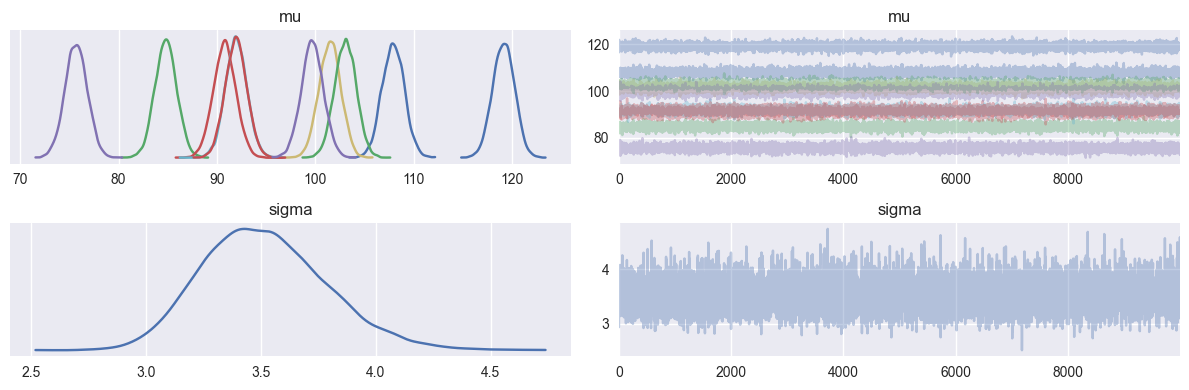

In [44]:
trace = az.from_numpyro(mcmc)
axes = az.plot_trace(trace, var_names=["mu", "sigma"])
plt.tight_layout()

plt.show()

In [55]:
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_predict = random.split(rng_key)


# posterior_samples = mcmc.get_samples()
# predictive = Predictive(model, posterior_samples)

# posterior_predictive_samples = predictive(rng_key_predict, data=data)

# # Step 3: Convert to ArviZ InferenceData object
# idata = az.from_numpyro(
#     posterior=mcmc,
#     posterior_predictive=posterior_predictive_samples,
#     predictions={"obs": data}
# )

# # Step 4: Plot posterior predictive checks with HDI
# az.plot_ppc(idata, num_pp_samples=100)
# plt.show()